## Предобработка данных и логистическая регрессия для задачи бинарной классификации

## Programming assignment

В задании вам будет предложено ознакомиться с основными техниками предобработки данных, а так же применить их для обучения модели логистической регрессии. Ответ потребуется загрузить в соответствующую форму в виде 6 текстовых файлов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Описание датасета

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [2]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

In [3]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

## Предобработка данных

Базовым этапом в предобработке любого датасета для логистической регрессии будет кодирование категориальных признаков, а так же удаление или интерпретация пропущенных значений (при наличии того или другого).

In [4]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [5]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

Также в нём присутствуют пропущенные значения. Очевидны решением будет исключение всех данных, у которых пропущено хотя бы одно значение. Сделаем это:

In [6]:
data.dropna().shape

(213, 39)

Видно, что тогда мы выбросим почти все данные, и такой метод решения в данном случае не сработает.

Пропущенные значения можно так же интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию (данный способ является самым естественным, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется)

##  Задание 0. Обработка пропущенных значений.
1. Заполните пропущенные вещественные значения в X нулями и средними по столбцам, назовите полученные датафреймы X_real_zeros и X_real_mean соответственно. 
2. Все категориальные признаки в X преобразуйте в строки, пропущенные значения требуется также преобразовать в какие-либо строки, которые не являются категориями (например, 'NA'), полученный датафрейм назовите X_cat.

In [1]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

In [10]:
means = calculate_means(X[numeric_cols])

In [11]:
means['RFCD.Percentage.1']

74.832348199892607

In [12]:
def NanChZero(datafr):
    datawork = datafr
    for item in datawork.columns:
        datawork[item].fillna(0, inplace=True)
    return datawork

def NanChMeans(datafr):
    datawork = datafr
    means = calculate_means(X[numeric_cols])
    for item in datawork.columns:
        datawork[item].fillna(means[item], inplace=True)
    return datawork

X_real_zeros=X[numeric_cols].fillna(0)
X_real_mean=NanChMeans(X[numeric_cols])

C:\Users\user\Anaconda2\lib\site-packages\pandas\core\generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [14]:
def NanChNA(datafr):
    datawork = datafr
    for item in datawork.columns:        
        datawork[item].fillna('NA', inplace=True)
    for item in datawork.columns:
        datawork[item]=datawork[item].astype(str)
    return datawork
X_cat = X[categorical_cols].applymap(str).fillna('NA')

## Преобразование категориальных признаков.

В предыдущей ячейке мы разделили наш датасет ещё на две части: в одной присутствуют только вещественные признаки, в другой только категориальные. Это понадобится нам для раздельной последующей обработке этих данных, а так же для сравнения качества работы тех или иных методов.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

In [16]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

Для построения метрики качества по результату обучения требуется разделить исходный датасет на обучающую и тестовую выборки.

In [17]:
from sklearn.cross_validation import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh,
                                   test_size=0.3, 
                                   random_state=0)

## Задание 1. Сравнение способов заполнения вещественных пропущенных значений.
1. Составьте две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой - средними. 
2. Обучите на них логистическую регрессию, подбирая параметры из заданной сетки param_grid по методу кросс-валидации с числом фолдов cv=3.
3. Постройте два графика оценок точности +- их стандратного отклонения в зависимости от гиперпараметра и убедитесь, что вы действительно нашли её максимум. Также обратите внимание на большую дисперсию получаемых оценок (уменьшить её можно увеличением числа фолдов cv).
4. Получите две метрики качества AUC ROC на тестовой выборке и сравните их между собой. Какой способ заполнения пропущенных вещественных значений работает лучше? В дальнейшем для выполнения задания в качестве вещественных признаков используйте ту выборку, которая даёт лучшее качество на тесте.
5. Передайте два значения AUC ROC (сначала для выборки, заполненной средними, потом для выборки, заполненной нулями) в функцию write_answer_1 и запустите её. Полученный файл является ответом на 1 задание.

Вообще говоря, не вполне логично оптимизировать на кросс-валидации заданный по умолчанию в классе логистической регрессии функционал accuracy, а измерять на тесте AUC ROC, но это, как и ограничение размера выборки, сделано для ускорения работы процесса кросс-валидации.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
def write_answer_1(auc_1, auc_2):
    auc = (auc_1 + auc_2)/2
    with open("preprocessing_lr_answer1.txt", "w") as fout:
        fout.write(str(auc))
        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

In [21]:
dataZeros_train = np.hstack((X_train_real_zeros,X_train_cat_oh))
dataZeros_test = np.hstack((X_test_real_zeros,X_test_cat_oh))
dataMean_train =np.hstack((X_train_real_mean,X_train_cat_oh))
dataMean_test =np.hstack((X_test_real_mean,X_test_cat_oh))

Метки функции предсказаний:

4320    0
2006    1
5689    0
472     1
1370    0
1457    1
5783    0
3484    1
1145    0
130     1
Name: Grant.Status, dtype: int64
[1 0 0 1 0 1 0 0 0 1]
Вероятности(т.к. функция логистическая):

[[ 0.252135    0.747865  ]
 [ 0.54382158  0.45617842]
 [ 0.89844845  0.10155155]
 [ 0.06644003  0.93355997]
 [ 0.91877138  0.08122862]
 [ 0.04248142  0.95751858]
 [ 0.91777932  0.08222068]
 [ 0.86245688  0.13754312]
 [ 0.83782003  0.16217997]
 [ 0.19134016  0.80865984]]
Лучшая функция:

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[ 0.01140464  0.01124229  0.00707679 ...,  1.07070579  0.08169429
  -0.08850465]]
Лучший параметр функции:

{'C': 0.1}


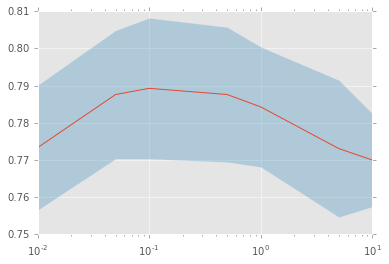

0.887003171437


In [22]:
estimator=LogisticRegression(penalty='l2', random_state = 0, class_weight='balanced', n_jobs=4)
optimizer = GridSearchCV(estimator, param_grid, scoring = 'accuracy', cv=cv)
optimizer.fit(dataZeros_train,y_train)
print 'Метки функции предсказаний:\n'
print y_test[:10]
print optimizer.predict(dataZeros_test)[:10]
print 'Вероятности(т.к. функция логистическая):\n'
print optimizer.predict_proba(dataZeros_test)[:10]
print 'Лучшая функция:\n'
print optimizer.best_estimator_
print 'Коэффициенты лучшей функции:\n'
print optimizer.best_estimator_.coef_
print 'Лучший параметр функции:\n'
print optimizer.best_params_
plot_scores(optimizer)
auc_zeros=roc_auc_score(y_test, optimizer.predict_proba(dataZeros_test)[:,1])
print auc_zeros

Метки функции предсказаний:

4320    0
2006    1
5689    0
472     1
1370    0
1457    1
5783    0
3484    1
1145    0
130     1
Name: Grant.Status, dtype: int64
[1 0 0 1 0 1 0 0 0 1]
Вероятности(т.к. функция логистическая):

[[ 0.26717591  0.73282409]
 [ 0.54023557  0.45976443]
 [ 0.89296188  0.10703812]
 [ 0.07234531  0.92765469]
 [ 0.91121504  0.08878496]
 [ 0.04613978  0.95386022]
 [ 0.92498409  0.07501591]
 [ 0.85819592  0.14180408]
 [ 0.85181423  0.14818577]
 [ 0.19447014  0.80552986]]
[ 0.73282409  0.45976443  0.10703812 ...,  0.06581557  0.10070631
  0.13997003]
Лучшая функция:

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[ 0.10760043  0.107776    0.10362792 ...,  1.0615058   0.10449077
  -0.09960759]]
Лучший параметр функции:


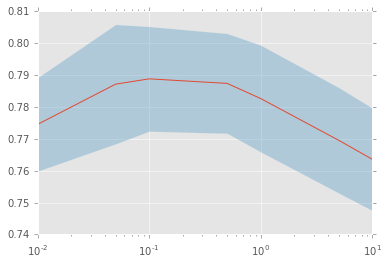

0.888062379432


In [23]:
estimator=LogisticRegression(penalty='l2', random_state = 0, class_weight='balanced', n_jobs=4)
optimizer = GridSearchCV(estimator, param_grid, scoring = 'accuracy', cv=cv)
optimizer.fit(dataMean_train,y_train)
print 'Метки функции предсказаний:\n'
print y_test[:10]
print optimizer.predict(dataMean_test)[:10]
print 'Вероятности(т.к. функция логистическая):\n'
print optimizer.predict_proba(dataMean_test)[:10]
print optimizer.predict_proba(dataMean_test)[:,1]
print 'Лучшая функция:\n'
print optimizer.best_estimator_
print 'Коэффициенты лучшей функции:\n'
print optimizer.best_estimator_.coef_
print 'Лучший параметр функции:\n'
print optimizer.best_params_
plot_scores(optimizer)
auc_mean=roc_auc_score(y_test, optimizer.predict_proba(dataMean_test)[:,1])
print auc_mean

Метки функции предсказаний:

4320    0
2006    1
5689    0
472     1
1370    0
1457    1
5783    0
3484    1
1145    0
130     1
Name: Grant.Status, dtype: int64
[1 0 0 1 1 1 0 0 0 1]
Вероятности(т.к. функция логистическая):

[[ 0.26121298  0.73878702]
 [ 0.5444149   0.4555851 ]
 [ 0.86839997  0.13160003]
 [ 0.07671541  0.92328459]
 [ 0.37354291  0.62645709]
 [ 0.11619039  0.88380961]
 [ 0.90348802  0.09651198]
 [ 0.77376997  0.22623003]
 [ 0.8125865   0.1874135 ]
 [ 0.23150455  0.76849545]]
Лучшая функция:

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[-0.35853677 -0.23124084  0.02043745 ...,  1.05249313  0.13873701
  -0.10690457]]
Лучший параметр функции:

{'C': 0.1}


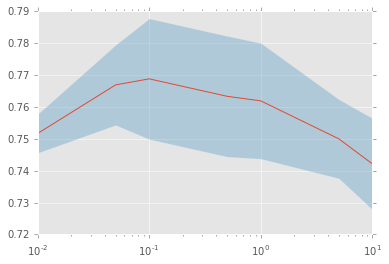

0.8517832682258637

In [24]:
estimator=LogisticRegression(penalty='l2', random_state = 0, class_weight='balanced', n_jobs=4)
optimizer = GridSearchCV(estimator, param_grid, scoring = 'accuracy', cv=cv)
optimizer.fit(X_train_cat_oh,y_train)
print 'Метки функции предсказаний:\n'
print y_test[:10]
print optimizer.predict(X_test_cat_oh)[:10]
print 'Вероятности(т.к. функция логистическая):\n'
print optimizer.predict_proba(X_test_cat_oh)[:10]
print 'Лучшая функция:\n'
print optimizer.best_estimator_
print 'Коэффициенты лучшей функции:\n'
print optimizer.best_estimator_.coef_
print 'Лучший параметр функции:\n'
print optimizer.best_params_
plot_scores(optimizer)
roc_auc_score(y_test, optimizer.predict_proba(X_test_cat_oh)[:,1])

In [26]:
auc_zeros

0.88700317143702123

In [27]:
auc_mean

0.88806237943156663

In [28]:
write_answer_1(auc_zeros, auc_mean)

## Масштабирование вещественных признаков.

Попробуем улучшить качество классификации.

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_real_scaled=scaler.fit_transform(X_train_real_mean)
X_train_real_scaled=scaler.transform(X_train_real_scaled)

X_test_real_scaled=scaler.fit_transform(X_test_real_mean)
X_test_real_scaled=scaler.transform(X_test_real_scaled)

In [31]:
X_test_real_scaled

array([[ -2.84036747e+00,  -9.53995483e-01,  -6.70576102e-01, ...,
         -2.13316666e+02,  -8.97403757e-01,  -7.97111687e-01],
       [ -2.84797191e+00,  -9.60588513e-01,  -6.18510876e-01, ...,
         -2.13287719e+02,  -8.17776714e-01,  -7.82421161e-01],
       [ -2.81093653e+00,  -1.01077303e+00,  -6.70576102e-01, ...,
         -2.13316666e+02,  -4.49680444e-01,  -3.47294181e-01],
       ..., 
       [ -2.89922936e+00,  -8.97217937e-01,  -5.20380965e-01, ...,
         -2.13316666e+02,  -1.34512707e+00,  -6.47172518e-01],
       [ -2.89922936e+00,  -9.25606710e-01,  -4.45283397e-01, ...,
         -2.13375744e+02,  -1.34512707e+00,  -9.47050855e-01],
       [ -2.81093653e+00,  -1.01077303e+00,  -6.70576102e-01, ...,
         -2.13198510e+02,  -4.49680444e-01,  -4.74158444e-02]])

## Сравнение признаковых пространств.

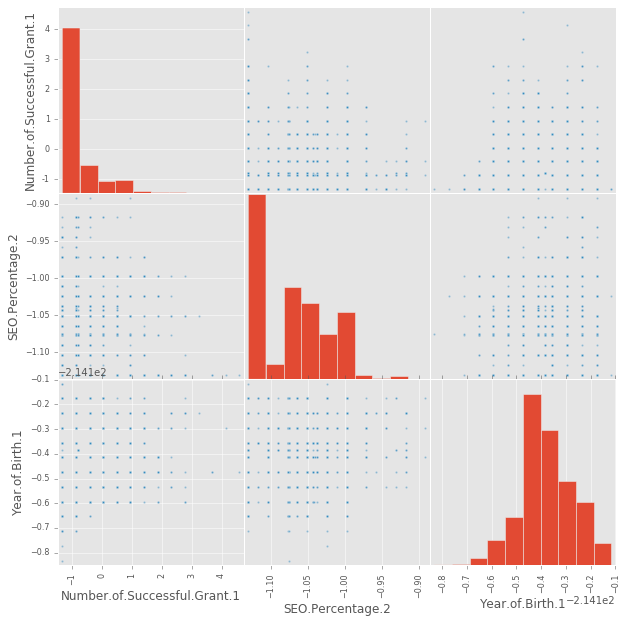

In [32]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков, как и их scatter-plots, выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне, тем самым повышая интерпретабельность результатов, а также лучше сочетаясь с идеологией регуляризации.

## Задание 2. Сравнение качества классификации до и после масштабирования вещественных признаков.
1. Обучите ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
2. Проверьте, был ли найден оптимум accuracy по гиперпараметрам во время кроссвалидации.
3. Получите значение ROC AUC на тестовой выборке, сравните с лучшим результатом, полученными ранее.
4. Запишите полученный ответ в файл при помощи функции write_answer_2.

In [33]:
dataMean_train =np.hstack((X_train_real_scaled,X_train_cat_oh))
dataMean_test =np.hstack((X_test_real_scaled,X_test_cat_oh))

Метки функции предсказаний:

4320    0
2006    1
5689    0
472     1
1370    0
1457    1
5783    0
3484    1
1145    0
130     1
Name: Grant.Status, dtype: int64
[1 0 0 1 0 1 0 0 0 1]
Вероятности(т.к. функция логистическая):

[[ 0.29500272  0.70499728]
 [ 0.57998327  0.42001673]
 [ 0.91296036  0.08703964]
 [ 0.07226713  0.92773287]
 [ 0.89615089  0.10384911]
 [ 0.05706774  0.94293226]
 [ 0.91845042  0.08154958]
 [ 0.85076383  0.14923617]
 [ 0.85180764  0.14819236]
 [ 0.21224032  0.78775968]]
[ 0.70499728  0.42001673  0.08703964 ...,  0.05969407  0.10260688
  0.11564641]
Лучшая функция:

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[ 0.02252677 -0.0031092  -0.05533878 ...,  1.05339417  0.08702321
  -0.08914935]]
Лучший параметр функции:

{'C':

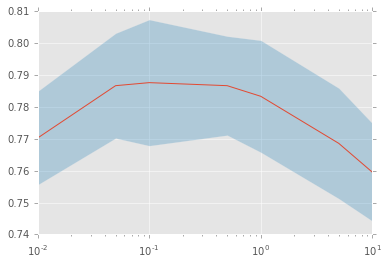

0.885722470182


In [34]:
estimator=LogisticRegression(penalty='l2', random_state = 0, n_jobs=4)
optimizer = GridSearchCV(estimator, param_grid, scoring = 'accuracy', cv=cv)
optimizer.fit(dataMean_train,y_train)
print 'Метки функции предсказаний:\n'
print y_test[:10]
print optimizer.predict(dataMean_test)[:10]
print 'Вероятности(т.к. функция логистическая):\n'
print optimizer.predict_proba(dataMean_test)[:10]
print optimizer.predict_proba(dataMean_test)[:,1]
print 'Лучшая функция:\n'
print optimizer.best_estimator_
print 'Коэффициенты лучшей функции:\n'
print optimizer.best_estimator_.coef_
print 'Лучший параметр функции:\n'
print optimizer.best_params_
plot_scores(optimizer)
auc_mean=roc_auc_score(y_test, optimizer.predict_proba(dataMean_test)[:,1])
print auc_mean

In [35]:
def write_answer_2(auc):
    with open("preprocessing_lr_answer2.txt", "w") as fout:
        fout.write(str(auc))
        
write_answer_2(auc_mean)

## Задание 3. Балансировка классов.
1. Обучите логистическую регрессию и гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированных выборках, полученных в предыдущем задании. Убедитесь, что вы нашли максимум accuracy по гиперпараметрам.
2. Получите метрику ROC AUC на тестовой выборке.
3. Сбалансируйте выборку, досэмплировав в неё объекты из меньшего класса. Для получения индексов объектов, которые требуется добавить в обучающую выборку, используйте следующую комбинацию вызовов функций:
        np.random.seed(0)
        indices_to_add = np.random.randint(...)
        X_train_to_add = X_train[y_train.as_matrix() == 1,:][indices_to_add,:]
   После этого добавьте эти объекты в начало или конец обучающей выборки. Дополните соответствующим      образом вектор ответов.
4. Получите метрику ROC AUC на тестовой выборке, сравните с предыдущим результатом.
5. Внесите ответы в выходной файл при помощи функции write_asnwer_3, передав в неё сначала ROC AUC для балансировки весами, а потом балансировки выборки вручную.

Метки функции предсказаний:

4320    0
2006    1
5689    0
472     1
1370    0
1457    1
5783    0
3484    1
1145    0
130     1
Name: Grant.Status, dtype: int64
[1 0 0 1 0 1 0 0 0 1]
Вероятности(т.к. функция логистическая):

[[ 0.25480222  0.74519778]
 [ 0.53407453  0.46592547]
 [ 0.89799239  0.10200761]
 [ 0.06166795  0.93833205]
 [ 0.87777325  0.12222675]
 [ 0.04822686  0.95177314]
 [ 0.90156058  0.09843942]
 [ 0.82922582  0.17077418]
 [ 0.8256439   0.1743561 ]
 [ 0.18787265  0.81212735]]
[ 0.74519778  0.46592547  0.10200761 ...,  0.07200606  0.11755941
  0.14321527]
Лучшая функция:

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[ 0.02169016 -0.00160309 -0.05400292 ...,  1.05764183  0.0863449
  -0.08849605]]
Лучший параметр функции:



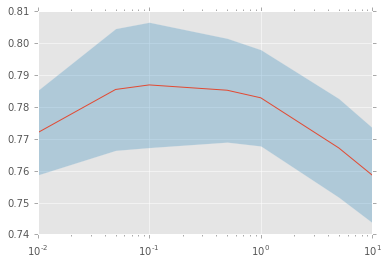

0.885879619032


In [38]:
dataMean_train =np.hstack((X_train_real_scaled,X_train_cat_oh))
dataMean_test =np.hstack((X_test_real_scaled,X_test_cat_oh))
estimator=LogisticRegression(penalty='l2', random_state = 0, class_weight='balanced', n_jobs=4)
optimizer = GridSearchCV(estimator, param_grid, scoring = 'accuracy', cv=cv)
optimizer.fit(dataMean_train,y_train)
print 'Метки функции предсказаний:\n'
print y_test[:10]
print optimizer.predict(dataMean_test)[:10]
print 'Вероятности(т.к. функция логистическая):\n'
print optimizer.predict_proba(dataMean_test)[:10]
print optimizer.predict_proba(dataMean_test)[:,1]
print 'Лучшая функция:\n'
print optimizer.best_estimator_
print 'Коэффициенты лучшей функции:\n'
print optimizer.best_estimator_.coef_
print 'Лучший параметр функции:\n'
print optimizer.best_params_
plot_scores(optimizer)
auc_mean_2=roc_auc_score(y_test, optimizer.predict_proba(dataMean_test)[:,1])
print auc_mean_2

In [39]:
np.random.seed(0)
number_to_add = np.sum(y_train==0)-np.sum(y_train==1)
indices_to_add = np.random.randint(np.sum(y_train==1), size = number_to_add)
X_train_to_add = dataMean_train[y_train.as_matrix() == 1,:][indices_to_add,:]
X_train_enhanced=np.append(dataMean_train,X_train_to_add, axis=0)
y_train_enhanced=np.append(y_train,(np.ones((number_to_add,1))))
print X_train_enhanced.shape
print y_train_enhanced.shape

(4632L, 5606L)
(4632L,)


Метки функции предсказаний:

4320    0
2006    1
5689    0
472     1
1370    0
1457    1
5783    0
3484    1
1145    0
130     1
Name: Grant.Status, dtype: int64
[ 1.  0.  0.  1.  0.  1.  0.  0.  0.  1.]
Лучшая функция:

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[ 0.12481152  0.01762432 -0.41988475 ...,  1.30810507  0.10032367
  -0.1142016 ]]
Лучший параметр функции:

{'C': 1}


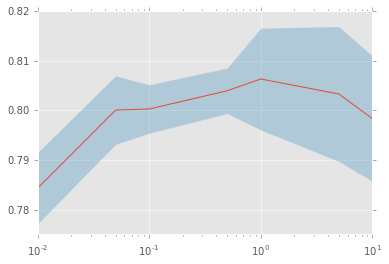

0.882701995048


In [40]:
estimator=LogisticRegression(penalty='l2', random_state = 0, class_weight='balanced', n_jobs=4)
optimizer = GridSearchCV(estimator, param_grid, scoring = 'accuracy', cv=cv)
optimizer.fit(X_train_enhanced,y_train_enhanced)
print 'Метки функции предсказаний:\n'
print y_test[:10]
print optimizer.predict(dataMean_test)[:10]
print 'Лучшая функция:\n'
print optimizer.best_estimator_
print 'Коэффициенты лучшей функции:\n'
print optimizer.best_estimator_.coef_
print 'Лучший параметр функции:\n'
print optimizer.best_params_
plot_scores(optimizer)
auc_mean_enhanced=roc_auc_score(y_test, optimizer.predict_proba(dataMean_test)[:,1])
print auc_mean_enhanced

In [41]:
def write_answer_3(auc_1, auc_2):
    auc = (auc_1 + auc_2) / 2
    with open("preprocessing_lr_answer3.txt", "w") as fout:
        fout.write(str(auc))
        
write_answer_3(auc_mean_2, auc_mean_enhanced)

## Задание 4. Стратификация выборки.

1. Разбейте выборки X_real_zeros и X_cat_oh на обучение и тест, применяя стратификацию.
2. Выполните масштабирование новых вещественных выборок, обучите классификатор и его гиперпараметры при помощи метода кросс-валидации, делая поправку на несбалансированные классы при помощи весов. Убедитесь в том, что нашли оптимум accuracy по гиперпараметрам.
3. Оцените качество классификатора метрике AUC ROC на тестовой выборке.
4. Полученный ответ передайте функции write_answer_4

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

In [45]:
from sklearn.cross_validation import train_test_split

(X_train_real_zeros_str, 
 X_test_real_zeros_str, 
 y_train_str, y_test_str) = train_test_split(X_real_zeros, y, 
                                             stratify=y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_cat_oh_str,
 X_test_cat_oh_str) = train_test_split(X_cat_oh,stratify=y,
                                   test_size=0.3, 
                                   random_state=0)



In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_real_scaled_str=scaler.fit_transform(X_train_real_zeros_str)
X_test_real_scaled_str=scaler.transform(X_test_real_zeros_str)

In [48]:
dataZeros_train_str = np.hstack((X_train_real_scaled_str,X_train_cat_oh_str))
dataZeros_test_str = np.hstack((X_test_real_scaled_str,X_test_cat_oh_str))

Метки функции предсказаний:

3068    0
3835    0
4872    0
2009    0
5197    0
2912    0
5988    1
2584    0
3776    1
4779    0
Name: Grant.Status, dtype: int64
[0 0 0 0 1 0 1 0 1 0]
Лучшая функция:

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[-0.00496596  0.02252652 -0.0381082  ...,  1.12004444  0.14868921
  -0.05885386]]
Лучший параметр функции:

{'C': 0.1}
параметр accuracy -  0.801666666667


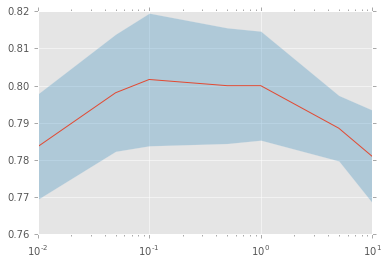

0.87934871305


In [50]:
estimator=LogisticRegression(penalty='l2', random_state = 0, class_weight='balanced', n_jobs=4)
optimizer = GridSearchCV(estimator, param_grid, scoring = 'accuracy', cv=cv)
optimizer.fit(dataZeros_train_str,y_train_str)
print 'Метки функции предсказаний:\n'
print y_test_str[:10]
print optimizer.predict(dataZeros_test_str)[:10]
print 'Лучшая функция:\n'
print optimizer.best_estimator_
print 'Коэффициенты лучшей функции:\n'
print optimizer.best_estimator_.coef_
print 'Лучший параметр функции:\n'
print optimizer.best_params_
print 'параметр accuracy - ',optimizer.best_score_
plot_scores(optimizer)
auc_mean_str=roc_auc_score(y_test_str, optimizer.predict_proba(dataZeros_test_str)[:,1])
print auc_mean_str

In [51]:
def write_answer_4(auc):
    with open("preprocessing_lr_answer4.txt", "w") as fout:
        fout.write(str(auc))
        
write_answer_4(auc_mean_str)

## Задание 5. Трансформация вещественных признаков.

1. Реализуйте преобразование вещественных признаков модели при помощи полиномиальных признаков степени 2
2. Постройте логистическую регрессию на новых данных, одновременно подобрав оптимальные гиперпараметры. Обращаем внимание, что в преобразованных признаках уже присутствует столбец, все значения которого равны 1, поэтому обучать дополнительно значение $b$ не нужно, его функцию выполняет один из весов $w$. В связи с этим во избежание линейной зависимости в датасете, в вызов класса логистической регрессии требуется передавать параметр fit_intercept=False. Для обучения используйте стратифицированные выборки с балансировкой классов при помощи весов, преобразованные признаки требуется заново отмасштабировать.
3. Получите AUC ROC на тесте и сравните данный результат с использованием обычных признаков.
4. Передайте полученный ответ в функцию write_answer_5.

In [56]:
(X_train_poly, 
 X_test_poly, 
 y_train_poly, y_test_poly) = train_test_split(X_real_zeros, y, 
                                             stratify=y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_cat_oh_poly,
 X_test_cat_oh_poly) = train_test_split(X_cat_oh, stratify=y,
                                   test_size=0.3, 
                                   random_state=0)

In [58]:
from sklearn.preprocessing import PolynomialFeatures
transform_str = PolynomialFeatures(2)
Data_train_poly = transform_str.fit_transform(X_train_poly)
Data_test_poly = transform_str.transform(X_test_poly)

In [59]:
scaler2 = StandardScaler()
X_train_poly_2 = scaler2.fit_transform(Data_train_poly)
X_test_poly_2=scaler2.transform(Data_test_poly)

In [60]:
dataZeros_train_poly = np.hstack((X_train_poly_2,X_train_cat_oh_poly))
dataZeros_test_poly = np.hstack((X_test_poly_2,X_test_cat_oh_poly))

Метки функции предсказаний:

3068    0
3835    0
4872    0
2009    0
5197    0
2912    0
5988    1
2584    0
3776    1
4779    0
Name: Grant.Status, dtype: int64
[0 0 0 0 0 0 1 0 1 0]
Лучшая функция:

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[ 0.         -0.00349982 -0.03242989 ...,  1.14647476  0.14884825
  -0.07101156]]
Лучший параметр функции:

{'C': 0.1}


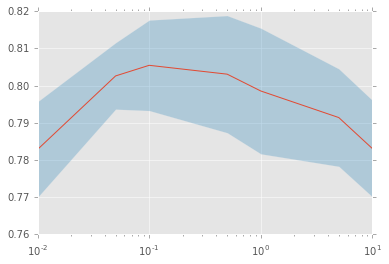

0.886995034307


In [61]:
estimator=LogisticRegression(penalty='l2', random_state = 0, class_weight='balanced', n_jobs=-1, fit_intercept=False)
optimizer = GridSearchCV(estimator, param_grid, scoring = 'accuracy', cv=cv)
optimizer.fit(dataZeros_train_poly,y_train_poly)
print 'Метки функции предсказаний:\n'
print y_test_poly[:10]
print optimizer.predict(dataZeros_test_poly)[:10]
print 'Лучшая функция:\n'
print optimizer.best_estimator_
print 'Коэффициенты лучшей функции:\n'
print optimizer.best_estimator_.coef_
print 'Лучший параметр функции:\n'
print optimizer.best_params_
plot_scores(optimizer)
auc_zeros_str_poly=roc_auc_score(y_test_poly, optimizer.predict_proba(dataZeros_test_poly)[:,1])
print auc_zeros_str_poly

In [62]:
def write_answer_5(auc):
    with open("preprocessing_lr_answer5.txt", "w") as fout:
        fout.write(str(auc))
        
write_answer_5(auc_zeros_str_poly)

## Задание 6. Отбор признаков при помощи регрессии Lasso.
1. Обучите регрессию Lasso на стратифицированных отмасштабированных выборках, используя балансировку классов при помощи весов.
2. Получите ROC AUC регрессии, сравните его с предыдущими результатами.
3. Найдите номера вещественных признаков, которые имеют нулевые веса в итоговой модели.
4. Передайте их список функции write_answer_6.

In [63]:
(X_train_real_zeros_lasso, 
 X_test_real_zeros_lasso, 
 y_train_lasso, y_test_lasso) = train_test_split(X_real_zeros, y, 
                                             stratify=y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_cat_oh_lasso,
 X_test_cat_oh_lasso) = train_test_split(X_cat_oh, stratify=y,
                                   test_size=0.3, 
                                   random_state=0)



In [64]:
scaler = StandardScaler()
X_train_real_scaled_lasso=scaler.fit_transform(X_train_real_zeros_lasso)
X_test_real_scaled_lasso=scaler.transform(X_test_real_zeros_lasso)

In [65]:
dataZeros_train_lasso = np.hstack((X_train_real_scaled_lasso,X_train_cat_oh_str))
dataZeros_test_lasso = np.hstack((X_test_real_scaled_lasso,X_test_cat_oh_str))

Метки функции предсказаний:

3068    0
3835    0
4872    0
2009    0
5197    0
2912    0
5988    1
2584    0
3776    1
4779    0
Name: Grant.Status, dtype: int64
[0 0 0 0 1 0 1 0 1 0]
Лучшая функция:

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l1', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[ 0.          0.         -0.05367849 -0.06496186 -0.0201857   0.          0.
  0.          0.01768474 -0.0013601   0.20829714  0.93246268 -1.24142918]
Лучший параметр функции:

{'C': 0.5}


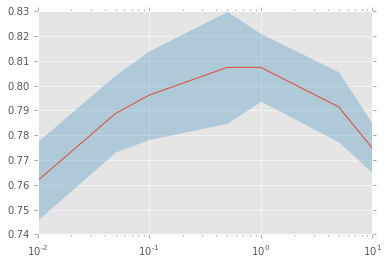

0.880668502679


In [66]:
estimator=LogisticRegression(penalty='l1', random_state = 0, class_weight='balanced', n_jobs=4)
optimizer = GridSearchCV(estimator, param_grid, scoring = 'accuracy', cv=cv)
optimizer.fit(dataZeros_train_lasso,y_train_str)
print 'Метки функции предсказаний:\n'
print y_test_str[:10]
print optimizer.predict(dataZeros_test_lasso)[:10]
print 'Лучшая функция:\n'
print optimizer.best_estimator_
print 'Коэффициенты лучшей функции:\n'
print optimizer.best_estimator_.coef_[0][:13]
print 'Лучший параметр функции:\n'
print optimizer.best_params_
plot_scores(optimizer)
auc_zero_lasso=roc_auc_score(y_test_str, optimizer.predict_proba(dataZeros_test_lasso)[:,1])
print auc_zero_lasso

In [67]:
optimizer.best_estimator_.coef_[0,:,]

array([ 0.        ,  0.        , -0.05367849, ...,  2.01983571,
        0.23330275,  0.        ])

In [68]:
def write_answer_6(features):
    with open("preprocessing_lr_answer6.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in features]))
        
write_answer_6(optimizer.best_estimator_.coef_[0][:13])